Found 275 audio files.


Text(0, 0.5, 'amplitude')

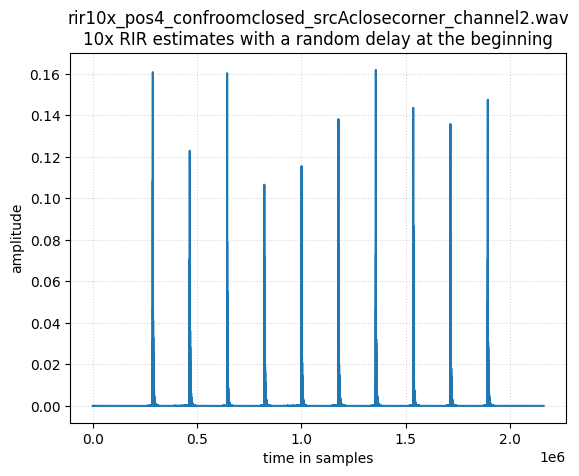

In [1]:
import os
import glob
import soundfile as sf
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tools.gcc_phat import gcc_phat

path_audio_conv = "deconvolved_audio_recs"

# List all audio files in the directory
audio_files = glob.glob(os.path.join(path_audio_conv, "*.wav"))
print(f"Found {len(audio_files)} audio files.")

file_path=random.choice(audio_files)
audio, samplerate = sf.read(file_path)

plt.figure()
# plt.plot(np.abs(audio[280000:320000]))
plt.plot(np.abs(audio))
plt.grid(True, ls=':', alpha=0.5)
plt.title(f"{os.path.basename(file_path)}\n10x RIR estimates with a random delay at the beginning")
plt.xlabel("time in samples")
plt.ylabel("amplitude")


In [2]:
from get_sweep import get_validation_sweep

_, _, T, fs = get_validation_sweep()

48000
[0. 0. 0. ... 0. 0. 0.]


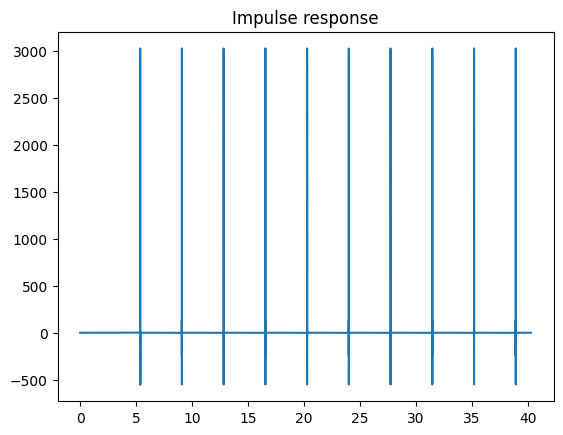

In [3]:
# Get the perfect 10x ESS estimation, to be used as basis for the gcc-phat
import scipy.signal as sig

# Get tapered sweep
# Parameters
amp = 0.5 
f1 = 100.
f2 = 20000.
N = 17. 
fs = 48000.
# Generate sweep
T = (2**N) / fs # 2.73066 Duration of sweep.
w1 = 2 * np.pi * f1
w2 = 2 * np.pi * f2
K = T * w1 / np.log(w2 / w1)
L = T / np.log(w2 / w1)
t = np.linspace(0, T - 1 / fs, int(fs * T))
sweep = amp * np.sin(K * (np.exp(t / L) - 1))
# Taper sweep
taper_percent = 0.01
taper_length = int(len(sweep) * taper_percent / 2)
short_window = np.hanning(2 * taper_length)
tapered_sweep = np.copy(sweep)
tapered_sweep[:taper_length] *= short_window[:taper_length]
tapered_sweep[-taper_length:] *= short_window[-taper_length:]

# Get sweep_times_10
sweep_times_10 = tapered_sweep
fs_int=int(fs)
print(fs_int)
print(np.zeros(fs_int))
one_second_of_silence=np.zeros(fs_int)
for i in range(4):
    sweep_times_10 = np.concatenate((one_second_of_silence,sweep_times_10))
for i in range(9):
    sweep_times_10 = np.concatenate((sweep_times_10,one_second_of_silence))
    sweep_times_10 = np.concatenate((sweep_times_10,tapered_sweep))
sweep_times_10 = np.concatenate((np.zeros(20),sweep_times_10,np.zeros(20)))

# Get Inverse filter
Inverse_filter_exp_scaling = np.exp(t / L)
inverse_tapered_sweep = tapered_sweep[::-1]/Inverse_filter_exp_scaling

# Deconvolve ESS sweeps
ideal_ir = sig.fftconvolve(sweep_times_10, inverse_tapered_sweep, mode='same')

plt.plot(np.arange(len(ideal_ir))/fs, ideal_ir)
plt.title('Impulse response')
plt.show()

In [ ]:
from tqdm import tqdm

my_list=[]
for i, file_path in tqdm(enumerate(audio_files)):
    audio, samplerate = sf.read(file_path)
    n_peak_list=[]
    height=np.absolute(audio).max()*0.35
    peaks, _ = find_peaks(audio, distance=T, height=height)
    my_list.append(len(peaks))

npeaks=np.array(my_list).flatten()

plt.plot(npeaks)
plt.title("number of peaks found with find_peaks\ndistance=T, height=35% of max amplitude")
plt.axhline(y = 10, color = 'r', linestyle = '--', alpha=0.3) 
plt.ylim(0,30)
plt.xlabel("audio_path index")
plt.ylabel("mean number of peaks")
plt.grid(True, ls=':', alpha=0.5)
plt.show()

It seems like the one of the ideal values to find 10 peaks for every audio recording is distance=T, and height=35% of max amplitude. (The peaks will be separated by at least an ESS and be non-noise)